In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from matplotlib import pyplot as plt
from datetime import datetime   

In [8]:
#Definicion de funciones

#Extraemos los datos  de Yahoo Finances, por el momento unicamente nos interesa el precio de cierre
def extract_date_yf(etiqueta,start_data,end_data,periocidad):

    df_aux = yf.download(etiqueta,start=start_data,end=end_data, interval = periocidad)
    return pd.DataFrame(df_aux['Close'])


#Creamos la primera estrategia y buscaremos evaluar su rentabilidad acumulada
def primera_estrategia(etiqueta,start_data,end_data,periocidad):

    #Extraccion de los datos
    df = extract_date_yf(etiqueta,start_data,end_data,periocidad)
    

    #Creacion de medias moviles (SECCION DE LOS INDICADORES)
    df['mv_rapida'] = df['Close'].rolling(30).mean()
    df['mv_lenta'] = df['Close'].rolling(60).mean()


    #Definimos una variable llamada "POSICION" que determina si compramos o vendemos
    df['posicion'] = np.nan

    df.loc[(df['mv_rapida'] > df['mv_lenta']) , 'posicion' ] = 1
    df.loc[(df['mv_rapida'] < df['mv_lenta'])  , 'posicion']  = -1


    #Porcentaje de variacion
    df['pct'] = df['Close'].pct_change()

    #Retorno obtenido en caso de seguir la posicion del dia anterior
    df['return'] = df['pct'] * df['posicion'].shift(1)

    #Retornamos el dataframe con todos los datos
    return df


#Mostramos el grafico del precio con los indicadores, el grafico de las posiciones abiertas y cerradas y las ganancias/perdidas acumuladas
def graficos(df):

    #==== GRAFICO NORMAL
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre')
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9')
    plt.plot(df['mv_lenta'], color='red', label='MV de 18')


    plt.legend(['Precio de cierre','MV rapida','MV lenta'])
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE POSICIONES ABIERTAS Y CERRADAS 

    #Lo que se hace aca es obtener los indices de cada posicion que tiene marcado 1 y -1
    idx_open = df.loc[df["posicion"] == 1].index
    idx_close = df.loc[df["posicion"] == -1].index


    # Configuración del estilo y tamaño
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de lineas punteadas - Como tenemos los indice de los 1 y -1, para buscar la Y usamos loc con el indice y el precio de cierre 
    plt.scatter(idx_open, df.loc[idx_open]['Close'], color ="green", marker="^")
    plt.scatter(idx_close, df.loc[idx_close]['Close'], color ="red", marker="v")


    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre' , alpha = 0.35)
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9', alpha = 0.35)
    plt.plot(df['mv_lenta'], color='red', label='MV de 18',alpha = 0.35)

    plt.legend()
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE VARICIONES ACUMULADA
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))
    plt.plot(df['return'].cumsum() * 100)
    plt.show()
    

In [ ]:
fecha_actual = end_data = str(datetime.now().year) + "-" + str(datetime.now().month) + "-" + str(datetime.now().day)

df = primera_estrategia("AMZN","2022-01-01",fecha_actual,"1d")

#Obtencion de media y varianza
u = df['pct'].mean()
var = df['pct'][df['pct'] < 0].std() #Teniendo en cuenta las perdidas

print("La media de las ganancia fue:",u)
print("La desviacion estandar de los datos de perdida, respecto a su media fue:",var)

#Distribucion de los datos
plt.hist(df['pct'])
plt.show()

#Estudiamos la distancia de los datos respecto a la media, y la dispersion
plt.figure(figsize=(10,10))
plt.plot(df['pct'] - u)
plt.axhline(y = var)
plt.axhline(y = -var)

plt.show()




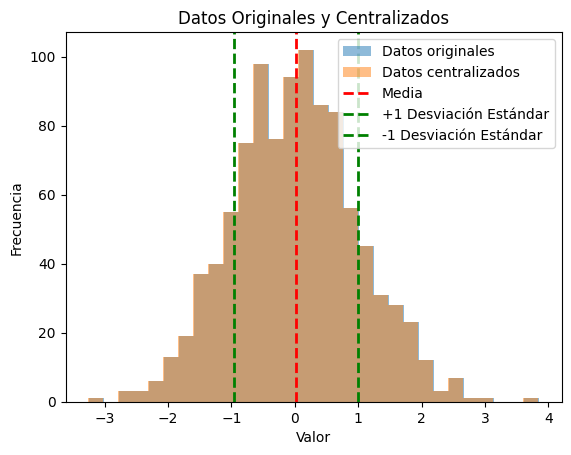

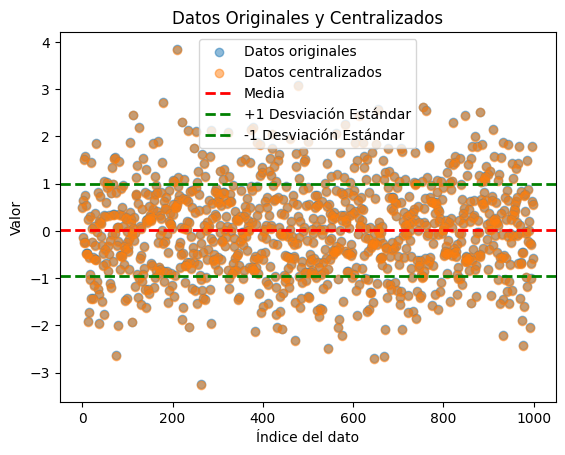

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos sintéticos con una distribución normal
np.random.seed(42)  # Establecer semilla para reproducibilidad
datos = np.random.randn(1000)  # Generar 1000 puntos con distribución normal (media=0, desviación estándar=1)

# Calcular la media y la desviación estándar
media = np.mean(datos)
desviacion_estandar = np.std(datos)

# Restar la media a los datos
datos_centralizados = datos - media

# Crear histograma
plt.hist(datos, bins=30, alpha=0.5, label='Datos originales')
plt.hist(datos_centralizados, bins=30, alpha=0.5, label='Datos centralizados')

# Añadir líneas verticales para la media y ±1 desviación estándar
plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(media + desviacion_estandar, color='green', linestyle='dashed', linewidth=2, label='+1 Desviación Estándar')
plt.axvline(media - desviacion_estandar, color='green', linestyle='dashed', linewidth=2, label='-1 Desviación Estándar')

# Configurar leyenda y etiquetas
plt.legend()
plt.title('Datos Originales y Centralizados')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

# Crear scatter plot
plt.scatter(range(len(datos)), datos, alpha=0.5, label='Datos originales')
plt.scatter(range(len(datos_centralizados)), datos_centralizados, alpha=0.5, label='Datos centralizados')

# Añadir líneas horizontales para la media y ±1 desviación estándar
plt.axhline(media, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axhline(media + desviacion_estandar, color='green', linestyle='dashed', linewidth=2, label='+1 Desviación Estándar')
plt.axhline(media - desviacion_estandar, color='green', linestyle='dashed', linewidth=2, label='-1 Desviación Estándar')

# Configurar leyenda y etiquetas
plt.legend()
plt.title('Datos Originales y Centralizados')
plt.xlabel('Índice del dato')
plt.ylabel('Valor')

# Mostrar el gráfico
plt.show()

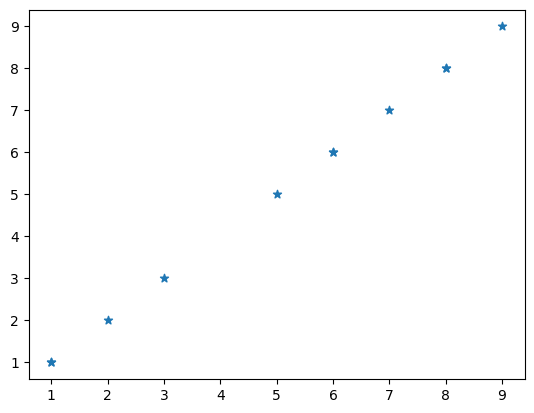

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Datos 
x = np.array([3, 8, 5, 6, 1, 9, 6, 7, 2, 1, 8])
y = np.array([4, 5, 2, 4, 6, 1, 4, 6, 5, 2, 3])

# Gráfico
fig, ax = plt.subplots()
ax.scatter(x, x, marker = "*")